In [82]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [83]:
BATCH_SIZE = 32
HIDDEN_SIZE = 256
LOAD_MODEL = True
USE_TRANSFER_LEARNING = True

In [84]:
class Graph2VecEmbeddingsDataset(Dataset):
    """Graph2Vec Embeddings dataset."""

    def __init__(self, embeddings, labels=None, transform=None):
        """
        Args:
            embeddings (pd.dataframe): Pandas Dataframe with the graph2vec embeddings
            labels : Labels indicating intelligence for the respective individual
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.embeddings = embeddings
        self.labels = labels
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):

        sample = torch.tensor(self.embeddings.iloc[idx]).float()

        if self.labels is not None:
            return sample, torch.tensor(self.labels.iloc[idx]).float()
        else:
            return sample

In [85]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, 1)
        )
        
        self.layers.apply(init_weights)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [93]:
PATH = './models/func_graph2vec_MLP_with_dropout_555'

In [94]:
model = MLP(128, 256)
model.load_state_dict(torch.load(PATH))
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [45]:
raw_y = pd.read_csv("intelligence_label.csv")
data = pd.read_csv("features/struct_embedding.csv")
y = []
for i in data['type']:
    subjid = i.split('/')[-1].split('_')[-1]
    for j in range(len(raw_y)):
        if subjid == raw_y['subjectkey'][j]:
            y.append(raw_y['nihtbx_totalcomp_uncorrected'][j])
data['y'] = y
data = data.drop("type", axis=1)

In [46]:
train_df, test_df = np.split(data.sample(frac=1, random_state=42), [int(.9*len(data))])
X_train, X_valid, y_train, y_valid = \
    train_test_split(train_df.iloc[:, 1:], train_df['y'], test_size=1/9, random_state=42)
y_test = test_df["y"]
X_test = test_df.drop("y", axis=1)

In [47]:
train_dataset = Graph2VecEmbeddingsDataset(embeddings=X_train, labels=y_train)
valid_dataset = Graph2VecEmbeddingsDataset(embeddings=X_valid, labels=y_valid)
test_dataset = Graph2VecEmbeddingsDataset(embeddings=X_test, labels=y_test)

In [48]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
dataiter = iter(train_loader)
embeddings, labels = dataiter.next()

print('embeddings shape on PyTroch : ', embeddings.size())
print('labels shape on PyTroch : ', labels.size())

embeddings shape on PyTroch :  torch.Size([32, 128])
labels shape on PyTroch :  torch.Size([32])


In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss() #will calculate RMSE next line

In [95]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 200

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (embeddings, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = model(embeddings)
        
        #print("Embeddings: ", embeddings, " Output: ", outputs, " Labels: ", labels.view(-1,1))
        
        loss = torch.sqrt(loss_fn(outputs, labels.view(-1,1)))
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
            
    model.eval()
    
    with torch.no_grad():
        for i, (embeddings, labels) in enumerate(valid_loader):
            outputs = model(embeddings)
            loss = torch.sqrt(loss_fn(outputs, labels.view(-1,1)))
            
            valid_losses.append(loss.item())
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses)))

epoch : 1, train loss : 0.2040, valid loss : 0.0468
epoch : 2, train loss : 0.2056, valid loss : 0.0715
epoch : 3, train loss : 0.1887, valid loss : 0.0819
epoch : 4, train loss : 0.2010, valid loss : 0.0902
epoch : 5, train loss : 0.1829, valid loss : 0.0902
epoch : 6, train loss : 0.1923, valid loss : 0.0439
epoch : 7, train loss : 0.2035, valid loss : 0.0519
epoch : 8, train loss : 0.2042, valid loss : 0.0545
epoch : 9, train loss : 0.1952, valid loss : 0.0255
epoch : 10, train loss : 0.1956, valid loss : 0.0459
epoch : 11, train loss : 0.2095, valid loss : 0.0656
epoch : 12, train loss : 0.1877, valid loss : 0.0559
epoch : 13, train loss : 0.1930, valid loss : 0.1399
epoch : 14, train loss : 0.1860, valid loss : 0.0675
epoch : 15, train loss : 0.1974, valid loss : 0.0656
epoch : 16, train loss : 0.2065, valid loss : 0.0817
epoch : 17, train loss : 0.2100, valid loss : 0.0352
epoch : 18, train loss : 0.2019, valid loss : 0.1028
epoch : 19, train loss : 0.1902, valid loss : 0.0569
ep

epoch : 155, train loss : 0.2031, valid loss : 0.0727
epoch : 156, train loss : 0.1919, valid loss : 0.0669
epoch : 157, train loss : 0.1904, valid loss : 0.1093
epoch : 158, train loss : 0.1877, valid loss : 0.1006
epoch : 159, train loss : 0.2025, valid loss : 0.0579
epoch : 160, train loss : 0.1801, valid loss : 0.0868
epoch : 161, train loss : 0.2052, valid loss : 0.0470
epoch : 162, train loss : 0.1917, valid loss : 0.1125
epoch : 163, train loss : 0.1918, valid loss : 0.0892
epoch : 164, train loss : 0.1999, valid loss : 0.0843
epoch : 165, train loss : 0.1894, valid loss : 0.0649
epoch : 166, train loss : 0.2034, valid loss : 0.0530
epoch : 167, train loss : 0.1947, valid loss : 0.0811
epoch : 168, train loss : 0.2110, valid loss : 0.0855
epoch : 169, train loss : 0.2097, valid loss : 0.0590
epoch : 170, train loss : 0.2055, valid loss : 0.0508
epoch : 171, train loss : 0.2113, valid loss : 0.1384
epoch : 172, train loss : 0.1826, valid loss : 0.0678
epoch : 173, train loss : 0.

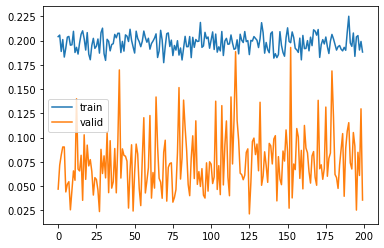

In [96]:
# func to struct
fig, ax = plt.subplots()
ax.plot(mean_train_losses, label='train')
ax.plot(mean_valid_losses, label='valid')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

plt.show()

In [97]:
model.eval()
test_losses = []
for i, (embeddings, labels) in enumerate(test_loader):
    
    pred = model(embeddings)
    loss = torch.sqrt(loss_fn(pred, labels.view(-1,1)))
    #print("Prediction:", pred.detach().numpy(), " Ground Truth:", labels.view(-1,1))
    test_losses.append(loss.item())
print("average test loss:", np.mean(test_losses))
print("average valid loss:", np.mean(mean_valid_losses))
print("average train loss:", np.mean(mean_train_losses))

average test loss: 0.7080142753464835
average valid loss: 0.07546502655372024
average train loss: 0.19752390950812765


In [92]:
from sklearn.metrics import r2_score
r2_score_average = []
for i, (embeddings, labels) in enumerate(test_loader):
    
    pred = model(embeddings)
    
    r2_score_average.append(r2_score(labels.view(-1,1).detach().numpy(),pred.detach().numpy()))
print("average r2_score:", np.mean(r2_score_average))

average r2_score: -0.08274145573503919


In [79]:
torch.save(model.state_dict(), "models/graph2vec_MLP_func2struct_with_dropout_555")

# struct to func
### 0.5 0.5 0.5
average test loss: 0.7230720051697322
이거 다시 해보기!!

### 0.5 0.4 0.4
average test loss: 0.7433243819645473

# func to struct
### 0.5 0.4 0.3
average test loss: 1.9211418628692627
??
??

### 0.5 0.5 0.5 - now going on
average test loss: 0.7079375173364367
average valid loss: 0.06544981951426182
average train loss: 0.20557052508840024